# Практическое задание 3

# Загрузка библиотек


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

from torch.utils.data import TensorDataset, DataLoader, Dataset

from torchvision import datasets
import pickle
# from google.colab import files
from tqdm import tqdm_notebook as tqdm

# Загрузка данных

In [2]:
MNIST = datasets.MNIST('./mnist', train=False, download=True, transform=None)
X_test, Y_test = MNIST.test_data, MNIST.test_labels

MNIST = datasets.MNIST('./mnist', train=True, download=True, transform=None)
X_train, Y_train = MNIST.train_data, MNIST.train_labels

In [3]:
X_train = X_train.reshape([X_train.shape[0], -1]).float()
X_test = X_test.reshape([X_test.shape[0], -1]).float()

# Функции модели

Определим логистическую регрессию, как однослойную нейросеть. 

In [4]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim = 20, output_dim = 10, device = 'cpu'):
        super(LogisticRegression, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(input_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        x = input
        return self.linear(x)

### Определим все функции для обучения модели

In [5]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
        model.zero_grad()
        
        output = model(batch_of_x)
        
        loss = loss_function(output, batch_of_y)
        loss.backward()
        optimizer.step()
     
        return
    
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)

    return

def full_train(num_of_epoch, batch_size, dataset, model, loss_function, optimizer, progress = None):
    iterations = range(num_of_epoch)
    if progress is not None:
        iterations = progress(iterations)

    for iteraration in iterations:

        batch_generator = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optimizer)
    
    return

## Функции из предыдущей статьи

In [6]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

# Переопределеный оптимизатор

Переопределим оптимизатор, чтобы оптимизировать только те переменые, которые не были удалены из модели

In [7]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            
# ==================================================
# Additition function
    def get_masks(self, kind = 'prune'):
        list_of_mask = []
        LIST_prune = []
        mask_vector = None
        if kind == 'prune':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    LIST_prune.append(prune_vector)
        mask_vector = torch.cat(LIST_prune)
        return mask_vector

    def prune(self, _noise_ = 0.1, method='random', **argv):
        if method == 'random':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    if int(_noise_*len(p_vector)) > 0:
                        prune_vector[torch.randperm(p_vector.shape[0])[:int(_noise_*len(p_vector))]] = 0
                        p_vector.data.mul_(prune_vector)

        elif method == 'OBD':
            if argv['hessian'] is None:
                pass
            else:
                for group in self.param_groups:
                    for p, h in zip(group['params'], argv['hessian']):
                        param_state = self.state[p]
                        if 'prune' not in param_state:
                            param_state['prune'] = torch.ones_like(p)

                        p_vector = p.view(-1)
                        score = (p*h).view(-1)
                        prune_vector = param_state['prune'].view(-1)
                        if int(_noise_*len(p_vector)) > 0:
                            prune_vector[torch.sort(score)[1][:int(_noise_*len(p_vector))]] = 0
                            p_vector.data.mul_(prune_vector)

            pass
    
    def deprune(self):
        for group in self.param_groups:
             for p in group['params']:
                param_state = self.state[p]
                param_state['prune'] = torch.ones_like(p)
# ==================================================

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
# ==================================================
# Addition in each step
                d_p = p.grad.data.detach()
                param_state = self.state[p]
    
                if 'prune' in param_state:
                    prune = param_state['prune']
                else:
                    prune = torch.ones_like(p)
                    param_state['prune'] = prune
# ==================================================                   
                    
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                # Exponential moving average of gradient values
                if 'exp_avg' not in state:
                    state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                if 'exp_avg_sq' not in state:
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    if 'max_exp_avg_sq' not in state:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                    
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2**(0.5)) / bias_correction1

                p.data.addcdiv_(-step_size, prune*exp_avg, denom)

        return loss

# Обучение

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
loss_function = torch.nn.CrossEntropyLoss()

In [10]:
train_device = TensorDataset(X_train.to(device), Y_train.to(device))
test_device = TensorDataset(X_test.to(device), Y_test.to(device))

In [11]:
model = LogisticRegression(input_dim=X_train.shape[1], output_dim = 10, device=device)

In [12]:
optimizer = Adam(model.parameters())

In [21]:
full_train(num_of_epoch = 100,
        batch_size = 64,
        dataset = train_device,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        progress = tqdm
       )

In [14]:
# torch.save(model.state_dict(), 'train_model.sv')

In [15]:
output = model(train_device[:][0])

loss = loss_function(output, train_device[:][1])

In [16]:
def new_hessian(model, hess):
    delta = 0
    output = []
    for obj in model.parameters():
        obj_size = torch.tensor(obj.size()).prod()
        output.append(hess[delta:delta+obj_size].view_as(obj))
        delta+=obj_size
    return output

In [17]:
%%time
hess = hessian(loss, model.parameters())

hhs = torch.diag(hess)
hs = new_hessian(model, hhs)

CPU times: user 31min 43s, sys: 1min, total: 32min 43s
Wall time: 17min 49s


In [23]:
_noise_ = np.linspace(0, 1, 10)
k = 5

random_accuracy = []
for i in tqdm(_range_):
    accuracy = []
    for _ in range(k):
#         model.load_state_dict(torch.load('dump/train_model.sv'))
        optimizer = Adam(model.parameters())
        optimizer.prune(_noise_=i, method='random', hessian=hs)

        full_train(num_of_epoch = 2,
            batch_size = 64,
            dataset = train_device,
            model = model,
            loss_function = loss_function,
            optimizer = optimizer
        )

        output = model(test_device[:][0])
        output.sum(dim = 1)
        output_f = torch.argmax(torch.softmax(output, dim = 1), dim = 1)
        
        frac = float((test_device[:][1] == output_f).sum())/test[:][1].shape[0]
        accuracy.append(frac)
    random_accuracy.append(accuracy)
  
random_accuracy_array = np.array(random_accuracy)


OBD_accuracy = []
for i in tqdm(_range_):
    optimizer = Adam(model.parameters())
    optimizer.prune(_noise_=i, method='OBD', hessian=hs)

    full_train(num_of_epoch = 2,
        batch_size = 64,
        dataset = train_device,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer
    )

    output = model(test_device[:][0])
    output.sum(dim = 1)
    _output_ = torch.argmax(torch.softmax(output, dim = 1), dim = 1)
    frac = float((test_device[:][1] == _output_).sum())/test_device[:][1].shape[0]
    OBD_accuracy.append(frac)
  
OBD_accuracy_array = np.array(OBD_accuracy)

In [24]:
_mean_ = np.mean(random_accuracy_array, axis = 1)
_std_ = np.std(random_accuracy_array, axis = 1)

# Иллюстрация

/Users/alarco/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Djvu Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


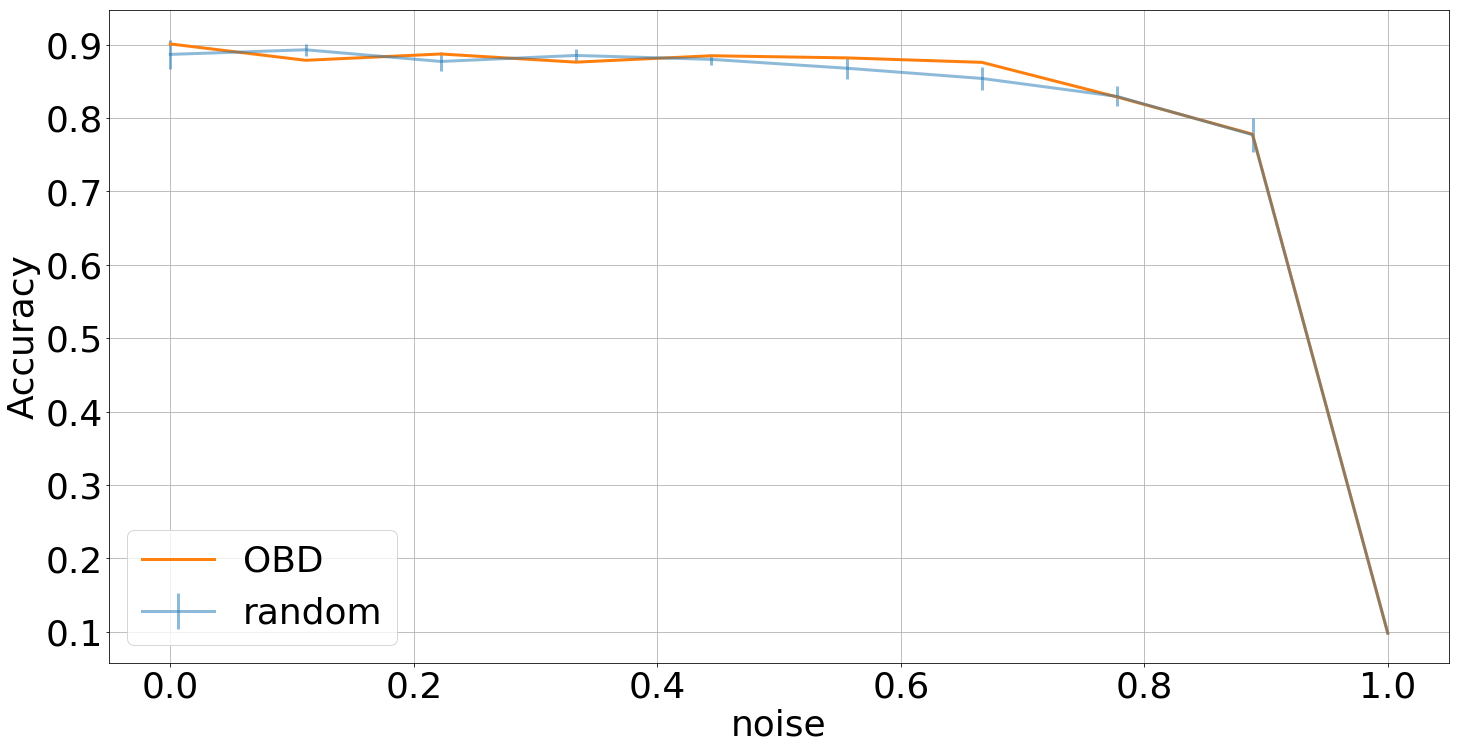

In [29]:
plt.errorbar(_noise_,_mean_,_std_,alpha = 0.5,label='random')
plt.plot(_noise_, OBD_accuracy_array, label='Optimal Brain Damage')

plt.legend(loc='best')
plt.grid()
plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['text.latex.unicode'] = True

plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}']
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

# Вывод

Optimal Brain Damage позволяет примерно до 68%, тогда как случайное удаление работает примерно до 60%. Заметим, что после 80% графики совпадают